In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os


In [182]:
# Read the CSV file
df_user = pd.read_csv('/Users/naroacorettisanchez/Documents/GitHub/DataSS/Rides/ride_demand_ss_1week_scattered.csv')
df_food= pd.read_csv('/Users/naroacorettisanchez/Documents/GitHub/DataSS/Deliveries/delivery_demand_ss_1week_scattered.csv')

In [183]:
df_food.columns

Index(['start_time', 'order_vertical', 'order_final_status',
       'start_to_pickup_flight_distance_in_meters',
       'pickup_to_delivery_flight_distance_in_meters',
       'courier_delivery_time_in_minutes', 'customer_delivery_time_in_minutes',
       'pickup_hexagon_id', 'delivery_hexagon_id', 'vehicle_type',
       'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude',
       'day'],
      dtype='object')

In [184]:
# Convert the 'Fecha de fin' column to a datetime object if it's not already
df_food['start_time'] = pd.to_datetime(df_food['start_time'])

# Set the 'Fecha de fin' column as the index
df_food.set_index('start_time', inplace=True)

# Resample the DataFrame with a frequency of 3 hours and create a list of DataFrames
df_list_food = [group for _, group in df_food.groupby(pd.Grouper(freq='1min'))]

In [185]:
df_user.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID_viaje', 'Estado cerrado', 'Duracion',
       'Id de estacion de inicio', 'Fecha de inicio',
       'Nombre de estacion de inicio', 'Fecha de fin',
       'Id de estacion de fin de viaje', 'Nombre de estacion de fin de viaje',
       'ID de ciclista', 'Msnbc de bicicleta', 'Moto identificador publico',
       'Modelo de bicicleta', 'Nombre de producto', 'start_lat', 'start_lon',
       'target_lat', 'target_lon', 'starttime', 'withinC', 'withinCend',
       'start_building', 'target_building'],
      dtype='object')

In [186]:
# Convert the 'Fecha de fin' column to a datetime object if it's not already
df_user['Fecha de fin'] = pd.to_datetime(df_user['Fecha de fin'])

# Set the 'Fecha de fin' column as the index
df_user.set_index('Fecha de fin', inplace=True)

# Resample the DataFrame with a frequency of 3 hours and create a list of DataFrames
df_list_user = [group for _, group in df_user.groupby(pd.Grouper(freq='1min'))]


In [187]:

def generate_hexbin(x_data_start, y_data_start, x_data_end, y_data_end):
    # Specify the hexbin parameters
    gridsize = 8
    
    # Compute hexbin counts for start points
    counts_start, x_edges, y_edges = np.histogram2d(x_data_start, y_data_start, bins=gridsize)
    
    # Compute hexbin counts for end points
    counts_end, _, _ = np.histogram2d(x_data_end, y_data_end, bins=(x_edges, y_edges))
    
    # Get hexbin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    
    # Create a DataFrame with centers, start counts, and end counts
    df_hexbin = pd.DataFrame({
        'center_x': np.repeat(x_centers, gridsize),
        'center_y': np.tile(y_centers, gridsize),
        'count_start': counts_start.flatten(),
        'count_end': counts_end.flatten()
    })
    
    # Add a new column for the difference between count_end and count_start
    df_hexbin['count_diff'] = df_hexbin['count_end'] - df_hexbin['count_start']
    
    return df_hexbin

df_counts_user = []

# Iterate through the list of DataFrames
for df_user in df_list_user:
    # Generate hexbin counts for start and end points
    df_centers_counts = generate_hexbin(df_user['start_lon'], df_user['start_lat'], df_user['target_lon'], df_user['target_lat'])
    
    # Append the resulting DataFrame to the list
    df_counts_user.append(df_centers_counts)



df_counts_food = []

# Iterate through the list of DataFrames
for df_food in df_list_food:
    # Generate hexbin counts for start and end points
    df_centers_counts = generate_hexbin(df_food['start_longitude'], df_food['start_latitude'], df_food['end_longitude'], df_food['end_latitude'])
    
    # Append the resulting DataFrame to the list
    df_counts_food.append(df_centers_counts)




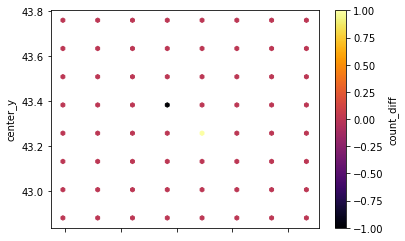

In [188]:
df_counts_user[0].plot.scatter(x='center_x', y='center_y', c='count_diff', cmap='inferno', marker='h')
plt.show()

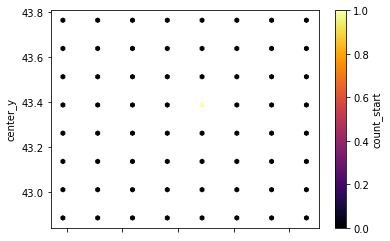

In [189]:
df_counts_food[0].plot.scatter(x='center_x', y='center_y', c='count_start', cmap='inferno', marker='h')

plt.show()

In [190]:
# Create a folder to store the images (if it doesn't exist)
output_folder = '/Users/naroacorettisanchez/Documents/GitHub/MultifunctionalVehicleFleets/results/BALANCE_MATRICES/small/user_ss_balance'
os.makedirs(output_folder, exist_ok=True)

# Initialize df_accumulated_user with the first DataFrame
df_accumulated_user = df_counts_user[0].copy()
df_accumulated_user['count_diff_accumulated'] = 0

df_all_user = []

# Iterate through the list of DataFrames (starting from the second DataFrame)
for i in range(len(df_counts_user)):
    # Accumulate the values for count_diff
    df_accumulated_user['count_diff_accumulated'] += df_counts_user[i]['count_diff']
    
    df_temp = df_counts_user[i].copy() 
    df_temp['count_diff_accumulated'] = df_accumulated_user['count_diff_accumulated'].copy()
    df_all_user.append(df_temp)

    # # Plot and save the image
    # plt.figure(figsize=(10, 8))
    # plt.scatter(df_accumulated_user['center_x'], df_accumulated_user['center_y'], c=df_accumulated_user['count_diff_accumulated'], cmap='inferno', s=1000)
    # plt.xlabel('X Label')
    # plt.ylabel('Y Label')
    # plt.title(f'Accumulated Hexbin Plot {i}')
    # plt.colorbar(label='Count Difference')

    # #Add the gap with the demand
    # plt.scatter(df_accumulated_user['center_x'], df_accumulated_user['center_y'], s=df_accumulated_user['count_start']*10, marker='h',facecolors='none', edgecolors='green', linewidths=2)
    
    # # Save the plot as an image in the output folder
    # output_path = os.path.join(output_folder, f'hexbin_plot_{i}.png')
    # plt.savefig(output_path)

    # # Show the plot if needed
    # plt.show()

    # # Close the current figure to free up resources
    # plt.close()

# Display the accumulated DataFrame
print(df_accumulated_user)

    center_x   center_y  count_start  count_end  count_diff  \
0  -2.408788  42.882934          0.0        0.0         0.0   
1  -2.408788  43.007934          0.0        0.0         0.0   
2  -2.408788  43.132934          0.0        0.0         0.0   
3  -2.408788  43.257934          0.0        0.0         0.0   
4  -2.408788  43.382934          0.0        0.0         0.0   
..       ...        ...          ...        ...         ...   
59 -1.533788  43.257934          0.0        0.0         0.0   
60 -1.533788  43.382934          0.0        0.0         0.0   
61 -1.533788  43.507934          0.0        0.0         0.0   
62 -1.533788  43.632934          0.0        0.0         0.0   
63 -1.533788  43.757934          0.0        0.0         0.0   

    count_diff_accumulated  
0                  -2485.0  
1                   -246.0  
2                   -245.0  
3                   -242.0  
4                   -224.0  
..                     ...  
59                  -148.0  
60         

In [191]:
for df in df_all_user:
    df['deficit'] = 0
    for i in range(len(df)):

        if df['count_diff_accumulated'][i] < 0:
            df['deficit'][i] = - df['count_diff'][i]
        else:
            df['deficit'][i] =  - df['count_diff'][i] - df['count_diff_accumulated'][i]

        if df['deficit'][i] < 0:
            df['deficit'][i] = 0

print(df_all_user[0])

total_deficit_user = 0

# Iterate through each DataFrame in df_all_user
for df in df_all_user:
    total_deficit_user += df['deficit'].sum()

print(total_deficit_user)

/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    center_x   center_y  count_start  count_end  count_diff  \
0  -2.408788  42.882934          0.0        0.0         0.0   
1  -2.408788  43.007934          0.0        0.0         0.0   
2  -2.408788  43.132934          0.0        0.0         0.0   
3  -2.408788  43.257934          0.0        0.0         0.0   
4  -2.408788  43.382934          0.0        0.0         0.0   
..       ...        ...          ...        ...         ...   
59 -1.533788  43.257934          0.0        0.0         0.0   
60 -1.533788  43.382934          0.0        0.0         0.0   
61 -1.533788  43.507934          0.0        0.0         0.0   
62 -1.533788  43.632934          0.0        0.0         0.0   
63 -1.533788  43.757934          0.0        0.0         0.0   

    count_diff_accumulated  deficit  
0                      0.0        0  
1                      0.0        0  
2                      0.0        0  
3                      0.0        0  
4                      0.0        0  
..             

In [192]:
# Create a folder to store the images (if it doesn't exist)
output_folder = '/Users/naroacorettisanchez/Documents/GitHub/MultifunctionalVehicleFleets/results/BALANCE_MATRICES/small/food_ss_balance'
os.makedirs(output_folder, exist_ok=True)


# Initialize df_accumulated_food with the first DataFrame
df_accumulated_food = df_counts_food[0].copy()
df_accumulated_food['count_diff_accumulated'] = 0

df_all_food = []

# Iterate through the list of DataFrames (starting from the second DataFrame)
for i in range(len(df_counts_food)):
    # Accumulate the values for count_diff
    df_accumulated_food['count_diff_accumulated'] += df_counts_food[i]['count_diff']
    
    df_temp = df_counts_food[i].copy() 
    df_temp['count_diff_accumulated'] = df_accumulated_food['count_diff_accumulated'].copy()
    df_all_food.append(df_temp)

    # # Plot and save the image
    # plt.figure(figsize=(10, 8))
    # plt.scatter(df_accumulated_food['center_x'], df_accumulated_food['center_y'], c=df_accumulated_food['count_diff_accumulated'], cmap='inferno', s=1000)
    # plt.xlabel('X Label')
    # plt.ylabel('Y Label')
    # plt.title(f'Accumulated Hexbin Plot {i}')
    # plt.colorbar(label='Count Difference')

    # #Add the gap with the demand
    # plt.scatter(df_accumulated_food['center_x'], df_accumulated_food['center_y'], s=df_accumulated_food['count_start']*10, marker='h',facecolors='none', edgecolors='green', linewidths=2)
    
    # # Save the plot as an image in the output folder
    # output_path = os.path.join(output_folder, f'hexbin_plot_{i}.png')
    # plt.savefig(output_path)

    # # Show the plot if needed
    # plt.show()

    # # Close the current figure to free up resources
    # plt.close()

# Display the accumulated DataFrame
print(df_accumulated_food)

    center_x   center_y  count_start  count_end  count_diff  \
0  -2.413341  42.887164          0.0        0.0         0.0   
1  -2.413341  43.012164          0.0        0.0         0.0   
2  -2.413341  43.137164          0.0        0.0         0.0   
3  -2.413341  43.262164          0.0        0.0         0.0   
4  -2.413341  43.387164          0.0        0.0         0.0   
..       ...        ...          ...        ...         ...   
59 -1.538341  43.262164          0.0        0.0         0.0   
60 -1.538341  43.387164          0.0        0.0         0.0   
61 -1.538341  43.512164          0.0        0.0         0.0   
62 -1.538341  43.637164          0.0        0.0         0.0   
63 -1.538341  43.762164          0.0        0.0         0.0   

    count_diff_accumulated  
0                   -602.0  
1                      0.0  
2                    -85.0  
3                    -51.0  
4                    -38.0  
..                     ...  
59                   -25.0  
60         

In [193]:
for df in df_all_food:
    df['deficit'] = 0
    for i in range(len(df)):
        if df['count_diff_accumulated'][i] < 0:
            df['deficit'][i] = - df['count_diff'][i]
        else:
            df['deficit'][i] =  - df['count_diff'][i] - df['count_diff_accumulated'][i]

        if df['deficit'][i] < 0:
            df['deficit'][i] = 0

print(df_all_food[0])

total_deficit_food = 0

# Iterate through each DataFrame in df_all_food
for df in df_all_food:
    total_deficit_food += df['deficit'].sum()

print(total_deficit_food)

/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

    center_x   center_y  count_start  count_end  count_diff  \
0  -2.413341  42.887164          0.0        0.0         0.0   
1  -2.413341  43.012164          0.0        0.0         0.0   
2  -2.413341  43.137164          0.0        0.0         0.0   
3  -2.413341  43.262164          0.0        0.0         0.0   
4  -2.413341  43.387164          0.0        0.0         0.0   
..       ...        ...          ...        ...         ...   
59 -1.538341  43.262164          0.0        0.0         0.0   
60 -1.538341  43.387164          0.0        0.0         0.0   
61 -1.538341  43.512164          0.0        0.0         0.0   
62 -1.538341  43.637164          0.0        0.0         0.0   
63 -1.538341  43.762164          0.0        0.0         0.0   

    count_diff_accumulated  deficit  
0                      0.0        0  
1                      0.0        0  
2                      0.0        0  
3                      0.0        0  
4                      0.0        0  
..             

In [194]:
# Create a folder to store the images (if it doesn't exist)
output_folder = '/Users/naroacorettisanchez/Documents/GitHub/MultifunctionalVehicleFleets/results/BALANCE_MATRICES/small/mixed_ss_balance'
os.makedirs(output_folder, exist_ok=True)

# Initialize df_accumulated_food with the first DataFrame
df_accumulated = df_counts_user[0].copy()
df_accumulated['count_diff_accumulated'] = 0

df_all_mixed = []

# Iterate through the list of DataFrames (starting from the second DataFrame)
for i in range(len(df_counts_user)):

    # Accumulate the values for count_diff
    df_accumulated['count_diff_accumulated'] += df_counts_user[i]['count_diff']
    df_accumulated['count_diff_accumulated'] += df_counts_food[i]['count_diff'] 


    df_temp = df_counts_food[i].copy() 
    df_temp['counts_start_user'] = df_counts_user[i]['count_start'].copy()
    df_temp['counts_start_food'] = df_counts_food[i]['count_start'].copy()
    df_temp['count_diff_user'] = df_counts_user[i]['count_diff'].copy()
    df_temp['count_diff_food'] = df_counts_food[i]['count_diff'].copy()
    df_temp['count_diff_accumulated'] = df_accumulated['count_diff_accumulated'].copy()
    df_all_mixed.append(df_temp)

    # # Plot and save the image
    # plt.figure(figsize=(10, 8))
    # plt.scatter(df_accumulated['center_x'], df_accumulated['center_y'], c=df_accumulated['count_diff_accumulated'], cmap='inferno', s=1000)
    # plt.xlabel('X Label')
    # plt.ylabel('Y Label')
    # plt.title(f'Accumulated Hexbin Plot {i}')
    # plt.colorbar(label='Count Difference')

    # #Add the gap with the demand
    # plt.scatter(df_accumulated['center_x'], df_accumulated['center_y'], s=df_accumulated['count_start']*10, marker='h',facecolors='none', edgecolors='green', linewidths=2)
    
    # # Save the plot as an image in the output folder
    # output_path = os.path.join(output_folder, f'hexbin_plot_{i}.png')
    # plt.savefig(output_path)

    # # Show the plot if needed
    # plt.show()

    # # Close the current figure to free up resources
    # plt.close()

# Display the accumulated DataFrame
print(df_accumulated)

IndexError: list index out of range

In [195]:
df_all_mixed[0]

,center_x,center_y,count_start,count_end,count_diff,counts_start_user,counts_start_food,count_diff_user,count_diff_food,count_diff_accumulated
0,-2.413341,42.887164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.413341,43.012164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-2.413341,43.137164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.413341,43.262164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.413341,43.387164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
59,-1.538341,43.262164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,-1.538341,43.387164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,-1.538341,43.512164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,-1.538341,43.637164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
for df in df_all_mixed:
    df['deficit'] = 0
    df['deficit_user'] = 0
    df['deficit_food'] = 0

    for i in range(len(df)):

        if df['count_diff_accumulated'][i] < 0:
            df['deficit'][i] = - df['count_diff_user'][i] - df['count_diff_food'][i]
            df['deficit_user'][i] = - df['count_diff_user'][i]
            df['deficit_food'][i] = - df['count_diff_food'][i]
        else:
            df['deficit'][i] =  - df['count_diff_user'][i] - df['count_diff_food'][i] - df['count_diff_accumulated'][i]
            df['deficit_food'][i] =  - df['count_diff_food'][i] - df['count_diff_accumulated'][i]
            df['deficit_user'][i] =  - df['count_diff_user'][i] - df['count_diff_accumulated'][i]

        if df['deficit'][i] < 0:
            df['deficit'][i] = 0

        if df['deficit_food'][i] < 0:
            df['deficit_food'][i] = 0

        if df['deficit_user'][i] < 0:
            df['deficit_user'][i] = 0

print(df_all_mixed[0])

total_deficit_mixed = 0
deficit_mixed_food = 0
deficit_mixed_user = 0

# Iterate through each DataFrame in df_all_food
for df in df_all_mixed:
    total_deficit_mixed += df['deficit'].sum()
    deficit_mixed_food += df['deficit_food'].sum()
    deficit_mixed_user += df['deficit_user'].sum()

print(total_deficit_mixed)

/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/naroacorettisanchez/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

    center_x   center_y  count_start  count_end  count_diff  \
0  -2.413341  42.887164          0.0        0.0         0.0   
1  -2.413341  43.012164          0.0        0.0         0.0   
2  -2.413341  43.137164          0.0        0.0         0.0   
3  -2.413341  43.262164          0.0        0.0         0.0   
4  -2.413341  43.387164          0.0        0.0         0.0   
..       ...        ...          ...        ...         ...   
59 -1.538341  43.262164          0.0        0.0         0.0   
60 -1.538341  43.387164          0.0        0.0         0.0   
61 -1.538341  43.512164          0.0        0.0         0.0   
62 -1.538341  43.637164          0.0        0.0         0.0   
63 -1.538341  43.762164          0.0        0.0         0.0   

    counts_start_user  counts_start_food  count_diff_user  count_diff_food  \
0                 0.0                0.0              0.0              0.0   
1                 0.0                0.0              0.0              0.0   
2        

In [197]:
print('Count deficit user: ', total_deficit_user)
print('Count deficit food: ', total_deficit_food)
print('Total deficit user + food: ', total_deficit_user + total_deficit_food)
print('Count deficit mixed: ', total_deficit_mixed)
print('Deficit mixed user: ', deficit_mixed_user)
print('Deficit mixed food: ', deficit_mixed_food)

Count deficit user:  15722
Count deficit food:  5556
Total deficit user + food:  21278
Count deficit mixed:  20765
Deficit mixed user:  15310
Deficit mixed food:  5551


In [198]:
pct_increase= (total_deficit_mixed - (total_deficit_user + total_deficit_food) )/(total_deficit_user + total_deficit_food)  * 100
print('Percentage increase: ', pct_increase)

Percentage increase:  -2.4109408779020582
